# A full cross-correlation analysis of 2021 L-band data

In this example, we show an example workflow, from the calibrated map cubes all the way to cross-power spectrum between MeerKLASS L-band deep-field survey and GAMA spectroscopic galaxies.

In [184]:
from meer21cm import PowerSpectrum
import matplotlib.pyplot as plt
import numpy as np
from meer21cm.util import pca_clean
from meer21cm.telescope import dish_beam_sigma
from meer21cm.util import center_to_edges
from meer21cm.plot import plot_map, plot_eigenspectrum, plot_pixels_along_los
from meer21cm.telescope import dish_beam_sigma
from meer21cm.grid import shot_noise_correction_from_gridding
from meer21cm.transfer import TransferFunction
from meer21cm.inference import SamplerEmcee, extract_model_fitting_inputs
import corner

## Step 1: Data read in and visualisation

Reading in the data:

In [182]:
file_dir = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
fits_file = file_dir+'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
counts_file = file_dir+'Nscan961_Npix_count_cube_p0.3d_sigma4.0_iter2.fits'
gal_file = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
ra_range_MK = (334, 357)
dec_range_MK = (-35, -26.5)
ra_range_GAMA = (339,351)
dec_range_GAMA = (-35,-30)
ps = PowerSpectrum(
    map_file=fits_file,
    counts_file=counts_file,
    gal_file=gal_file,
    beam_model='gaussian',
    beam_type='isotropic',
    band='L', # band and survey will produce some pre-defined cuts to select
    survey='meerklass_2021', # the clean frequency sub-band
    ra_range=ra_range_MK,
    dec_range=dec_range_MK,
)
# read in map_file
ps.read_from_fits()
# read in galaxy file
ps.read_gal_cat()
ps.ra_range = ra_range_GAMA
ps.dec_range = dec_range_GAMA
ps.trim_gal_to_range()
D_dish = 13.5 # Dish-diameter [metres]
sigma_ch = dish_beam_sigma(D_dish,ps.nu,)
# set the beam size
ps.sigma_beam_ch = sigma_ch
MKmap_orig = ps.data.copy()

The overlapping area between GAMA and MeerKLASS can be visualised:

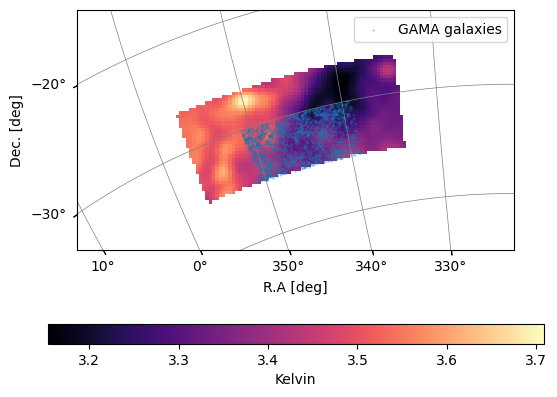

In [183]:
plot_map(MKmap_orig,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')
ax = plt.gca()
plt.scatter(ps.ra_gal,ps.dec_gal,transform=ax.get_transform('world'),
            s=1,label='GAMA galaxies',color='tab:blue',
            alpha=0.2
           )
plt.legend()

Examine the spectral structure of the map:

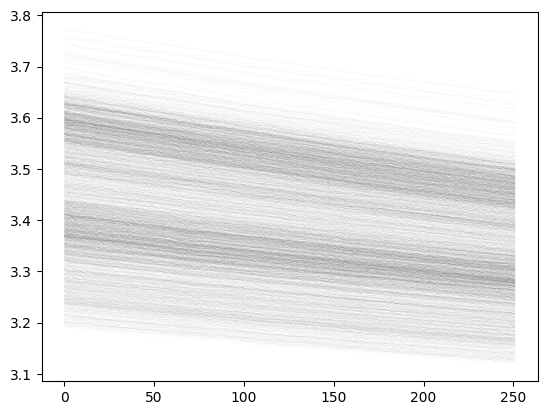

In [185]:
plot_pixels_along_los(ps.data,ps.W_HI)

In this example, since we have already examined the data in detail and known what frequency sub-band to select, during initialisation we have specified `band='L'` and `survey='meerklass_2021'`. For a new data cube, it is likely that you need to manually examine the spectral structure as well as the sampling of the data (`ps.W_HI`) to find the clean channels. You can then re-initialise a `ps` instance and add `nu_min=` and `nu_max=` argument to cut the data cube into the clean sub-band.

The pre-defined min and max for this data are:

In [186]:
ps.nu_min, ps.nu_max

(971000000.0, 1023800000.0)

## Step 2: PCA cleaning

After examining the data, we can perform PCA cleaning.

Since we are only interested in the GAMA cross-correaltion, here we first trim the map to only use the overlapping area:

In [4]:
ps.trim_map_to_range()

Perform PCA cleaning and visualise:

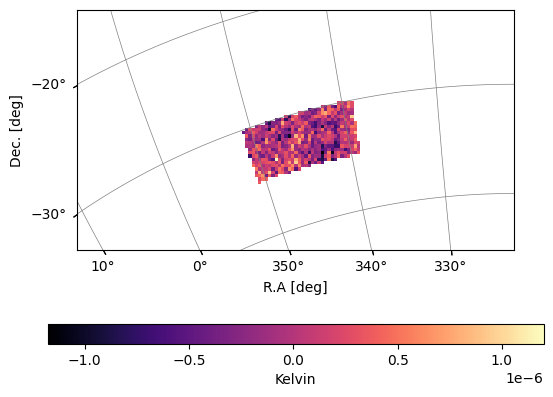

In [5]:
N_fg = 10
MKmap_clean, A_mat = pca_clean(MKmap_orig,N_fg,weights=ps.W_HI,mean_center=True, return_A=True)
plot_map(MKmap_clean,ps.wproj,W=ps.W_HI,cbar_label='Kelvin')

You can visualise the eigenmodes removed:

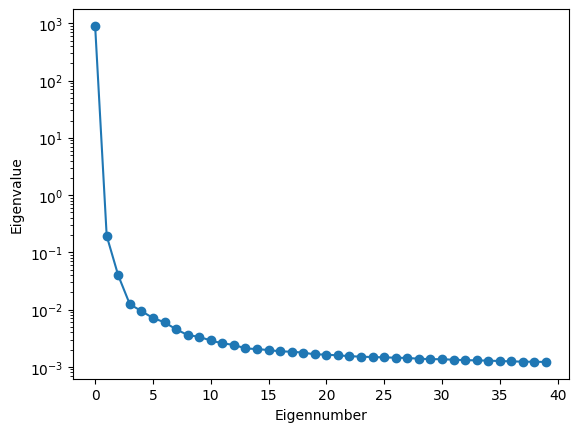

<Figure size 640x480 with 0 Axes>

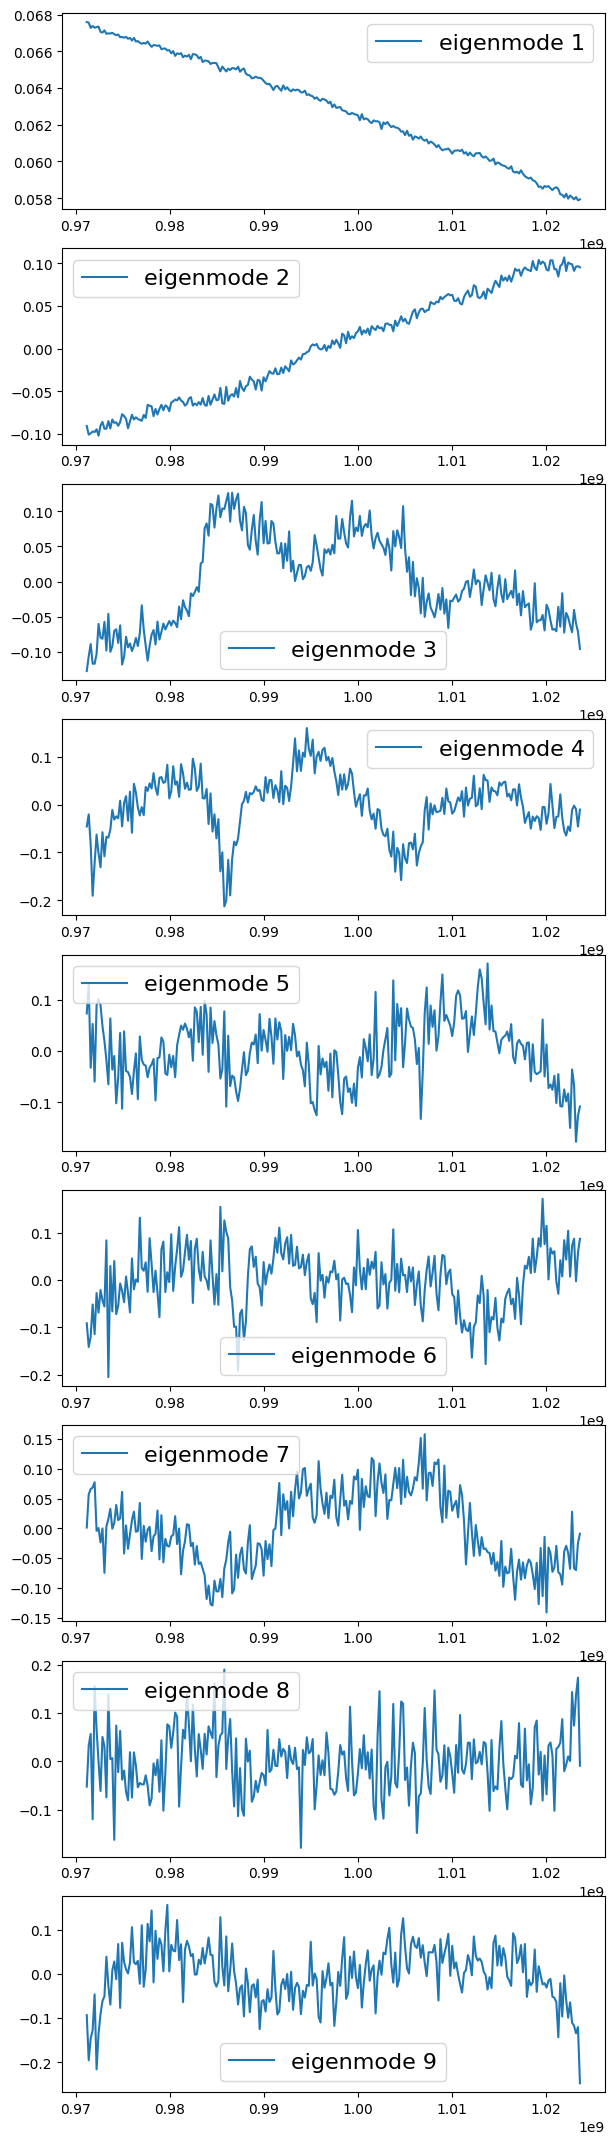

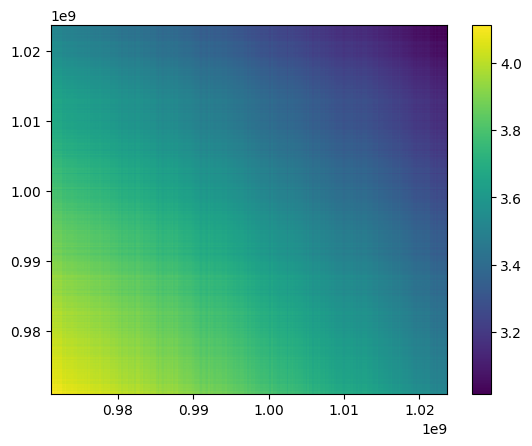

In [6]:
nu_edges = center_to_edges(ps.nu)
cov_map,eignumb,eigenval,V = pca_clean(MKmap_orig,N_fg=1,weights=ps.W_HI,return_analysis=True,mean_center=True) # weights included in covariance calculation
plot_eigenspectrum(np.array([eigenval]))
plt.figure()
Num = 9
chart = 100*Num + 11
plt.figure(figsize=(7,3*Num))
for i in range(Num):
    plt.subplot(chart + i)
    plt.plot(ps.nu,V[:,i],label='eigenmode %s'%(i+1))
    #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    plt.legend(fontsize=16)
plt.figure()
plt.pcolormesh(nu_edges,nu_edges,cov_map)
plt.colorbar()
plt.show()

## Step 3: gridding

Now let's start grid the residual map to a rectangular grid and perform power spectrum estimation:

In [99]:
# pass the cleaned data to ps
ps.data = MKmap_clean

# a relative factor, the rectangular grid resolution is 1/factor of the map cube resolution
ps.downres_factor_transverse = 1.5
ps.downres_factor_radial = 1.5

# this is box buffkick, negtive value means throwing away the edge of the lightcone
# to have a full sampling box
ps.box_buffkick = [-15,-15,0]
# grid scheme, nearest neighbour in this case
ps.grid_scheme = 'nnb'
# find the rectangular box that encloses the lightcone
ps.get_enclosing_box()
# grid HI data
hi_map_rg,_,_ =  ps.grid_data_to_field()
# grid galaxy data
gal_map_rg,_,_ =  ps.grid_gal_to_field()

You can visualise the gridded field and the sampling:

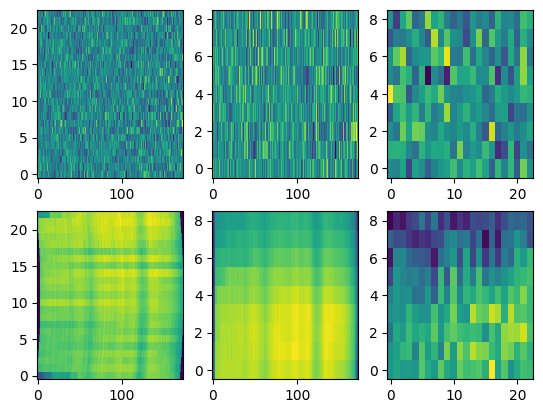

In [100]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    # first row is the gridded HI field
    axes[0,i].imshow(
        hi_map_rg.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    # second row is the sampling of pixels in the box grids
    axes[1,i].imshow(
        ps.counts_in_box.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

## Step 4: power spectrum estimation

Now let us pass the gridded fields and sampling to `ps` for power spectrum estimation:

In [108]:
# _1 stands for HI
ps.field_1 = hi_map_rg
ps.weights_1 = ps.counts_in_box # inverse noise variance weighting
# _2 stands for galaxy
ps.field_2 = gal_map_rg
ps.weights_2 = (ps.counts_in_box>0).astype('float') # where the lightcone actually occupies the box

# HI is already zero mean, with temp unit
ps.mean_center_1 = False 
ps.unitless_1 = False 

# galaxy number counts needs to be rescaled and zero-meaned
ps.mean_center_2 = True
ps.unitless_2 = True

# gridding compensation is applied to model
ps.compensate = True

# HI is further compensated due to map-making, galaxy is not a map and therefore not
ps.include_sky_sampling = [True, False]

# HI is attenuated by beam, galaxy is not
ps.include_beam = [True, False]

# apply a frequency taper, which is standard in radio observation to suppress chromatic structure
ps.apply_taper_to_field(1,axis=[2,])
ps.apply_taper_to_field(2,axis=[2,])


`meer21cm` deals with the calculation under the hood, including applying window function and all sorts of observation effects to the model power spectrum for comparison. The results are then stored in these attributes:

- `ps.auto_power_3d_1`: auto-power of field 1 data (HI).
- `ps.auto_power_3d_2`: auto-power of field 2 data (gal).
- `ps.cross_power_3d`: cross-power of data
- `ps.auto_power_tracer_1_model`: model auto-power of tracer 1 (HI)
- `ps.auto_power_tracer_2_model`: model auto-power of tracer 2 (gal)
- `ps.cross_power_tracer_model`: model cross-power

These results are all in the 3D k-grid, with their k-mode and $\mu$-mode specified by `ps.kmode` and `ps.mumode`.

To visualise the results, we also need to choose some 1D k-bin for averaging to the monopole:

In [109]:
nkbin = 10
kmin,kmax = 0.08,0.28 # in Mpc-1 h
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kbins *= ps.h # in Mpc-1, meer21cm does not use h-unit
# in Mpc-1 h
kcuts = [0.04,0.04,0.175,np.inf] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
# in Mpc-1
kcuts = np.array(kcuts) * ps.h
k_sel = (
    (np.abs(ps.k_perp<=kcuts[2]) * np.abs(ps.k_perp>kcuts[0]))[:,:,None] *
    (np.abs(ps.k_para<=kcuts[3]) * np.abs(ps.k_para>kcuts[1]))[None,None]
).astype('float')
ps.k1dbins = kbins

In [110]:
# 1D HI PS
pdata_1d_hi,keff_hi,nmodes_hi = ps.get_1d_power(ps.auto_power_3d_1,k1dweights=k_sel)
# 1D galaxy PS
pdata_1d_gg,keff_gg,nmodes_gg = ps.get_1d_power(ps.auto_power_3d_2,k1dweights=k_sel)
# 1D cross PS
pdata_1d_cross,keff_c,nmodes_c = ps.get_1d_power(ps.cross_power_3d,k1dweights=k_sel)
# galaxy shot noise, n_g = N_g/V_survey
# shot noise is modified due to gridding scheme
shot_noise = ps.survey_volume / ps.ra_gal.size * shot_noise_correction_from_gridding(ps.box_ndim,grid_scheme=ps.grid_scheme)
psn_1d_gg, _,_ = ps.get_1d_power(shot_noise, k1dweights=k_sel)


While it is not included in any current MeerKLASS data analysis, note that the averaging can then easily be extended to multi-order multipoles (in the parallel-plane limit). All you need to do is to multiply the Legendre polynomials to the 3D power in the `ps.get_1d_power` call.

We can perform sanity checks of the power spectrum amplitude by comparing against some model. You need to specify some input model choices:

In [111]:
bias_HI = 1.5
bias_gal = 1.8
omega_HI = 0.85e-3 / bias_HI
cross_coeff = 1.0
# pass model parameters to ps
ps.tracer_bias_1 = bias_HI
ps.tracer_bias_2 = bias_gal
ps.omega_hi = omega_HI
# HI has temp unit
ps.mean_amp_1 = 'average_hi_temp'
# the so-called "r" 
ps.cross_coeff = cross_coeff
# FoG effect
ps.sigma_v_1 = 200.0
ps.sigma_v_2 = 200.0
# use linear matter power spectrum, can be `nonlinear`
ps.ps_type = 'linear'

In [112]:
pmod_1d_c,_,_ = ps.get_1d_power(ps.cross_power_tracer_model,k1dweights=k_sel)
pmod_1d_gg,_,_ = ps.get_1d_power(ps.auto_power_tracer_2_model,k1dweights=k_sel)

Text(0.5, 1.0, 'Galaxy auto-power spectrum')

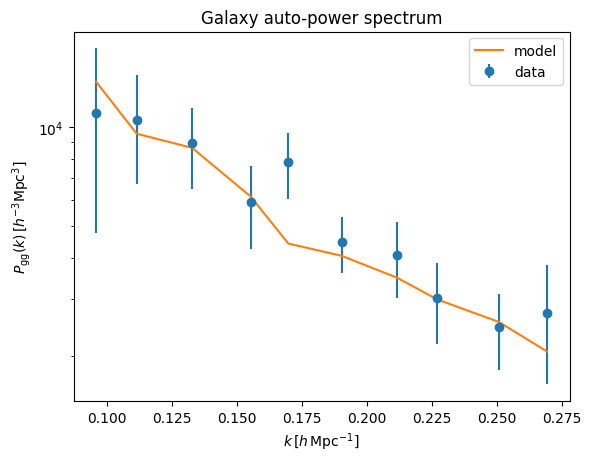

In [187]:
perror_1d_gg = (pdata_1d_gg)/np.sqrt(nmodes_gg)

plt.errorbar(keff_gg/ps.h,(pdata_1d_gg-psn_1d_gg)*ps.h**3,
             yerr=perror_1d_gg*ps.h**3,
             ls='none',
             marker='o',
             label='data')
plt.plot(keff_gg/ps.h,pmod_1d_gg*ps.h**3,label='model')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm gg}(k)\,[h^{-3}{\rm Mpc}^3]$')
plt.title('Galaxy auto-power spectrum')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

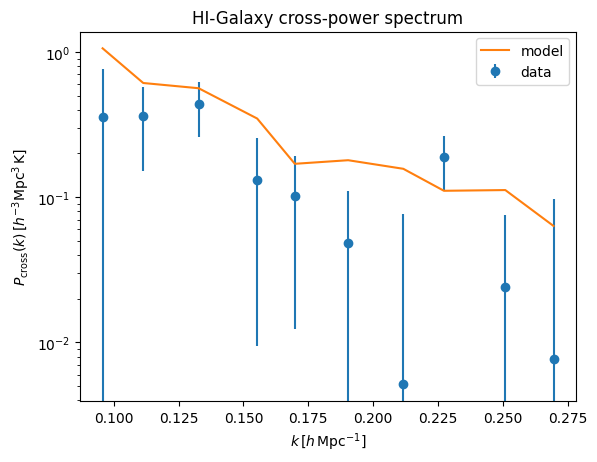

In [188]:
# a naive error bar 
perror_1d_c = np.sqrt((pdata_1d_cross**2 + pdata_1d_hi * pdata_1d_gg)/2)/np.sqrt(nmodes_c-1)
#k_factor = keff_c**2 / ps.h**2
k_factor = 1.0
plt.errorbar(keff_c/ps.h,(pdata_1d_cross)*ps.h**3 * k_factor,
             yerr=perror_1d_c*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')
plt.plot(keff_c/ps.h, pmod_1d_c*ps.h**3 * k_factor, label='model')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,[h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

HI auto-power is noise dominated:

Text(0.5, 1.0, 'HI auto-power spectrum')

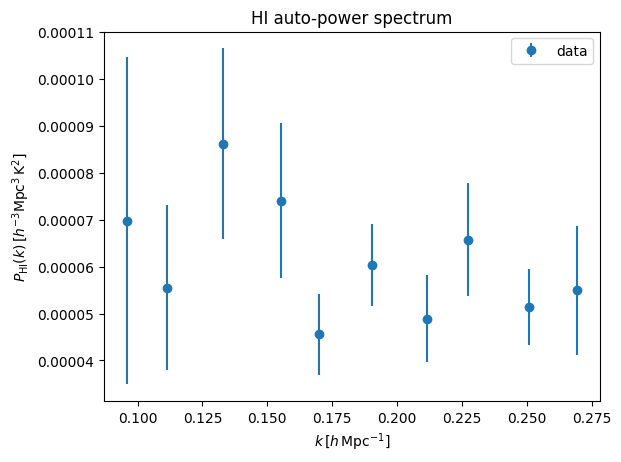

In [189]:
perror_1d_hi = (pdata_1d_hi)/np.sqrt(nmodes_hi)

plt.errorbar(keff_gg/ps.h,(pdata_1d_hi)*ps.h**3,
             yerr=perror_1d_hi*ps.h**3,
             ls='none',
             marker='o',
             label='data')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[h^{-3}{\rm Mpc}^3\,{\rm K}^2]$')
plt.title('HI auto-power spectrum')

## Step 5: apply transfer function correction

As one can see, the galaxy power gives reasonable result, whereas the cross-power clearly suffers from signal loss. Let us apply transfer function correction to it.

`meer21cm` automates the transfer function correction procedure. The transfer function calculation essentially generates mock HI data and injects it into the original map cube. It then performs PCA and compares the cleaned mock with the input mock (see 2302.07034 for details). In `meer21cm`, the `TransferFunction` class takes in the power spectrum analysis instance `ps` as an input. Therefore, it automatically matches the mock pipeline with the data analysis pipeline, and applies the same gridding, modelling, compensation etc as the data analysis. Additionally, you need to also put in the specifications of PCA as well as some mock settings that are not in `ps`. See the API summary for more details.

Additionally, it automatically runs the calculation in parallel and supports `multiprocessing` as well as `mpi4py` pools. You may need to manually configure the mpi installation to enable using `mpi4py`.

In [ ]:
# on linux systems this is typically needed if you are running in parallel through mp
import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# pass the ps specficiations as well as some simulation settings
tf = TransferFunction(
    ps, N_fg=N_fg, 
    # generate mock data on a high-resolution grid, then to average it to sky map for injection
    highres_sim=2, upres_transverse=2, upres_radial=2,
    uncleaned_data=MKmap_orig, # inject into the map data to reperform PCA
    num_process=32, # number of available cpus to run parallel calculation
    pca_map_weights=ps.W_HI.astype('float'),
)
# run a null test as well, 100 realisations
null_test_arr = tf.run(range(100), type='null', return_power_3d=False)
# run tf calculation
results_arr = tf.run(range(100), type='cross', return_power_3d=False, return_power_1d=True)

In [119]:
# organise the results of 100 realisations
tf_1d_arr = []
pnull_1d_arr = []
pmock_1d_cross_arr = []
pmock_1d_cross_cleaned_arr = []
for i in range(len(results_arr)):
    tf_1d_arr.append(results_arr[i][0])
    pnull_1d_arr.append(null_test_arr[i][0])
    pmock_1d_cross_arr.append(results_arr[i][1])
    pmock_1d_cross_cleaned_arr.append(results_arr[i][2])

tf_1d_arr = np.array(tf_1d_arr)
pnull_1d_arr = np.array(pnull_1d_arr)
pmock_1d_cross_arr = np.array(pmock_1d_cross_arr)
pmock_1d_cross_cleaned_arr = np.array(pmock_1d_cross_cleaned_arr)

The transfer function calculation returns `tf_1d_arr`, which is the ratio between `pmock_1d_cross_arr` and `pmock_1d_cross_cleaned_arr`. Using this, we can apply a rescaling correction to the measured cross-power, and also do covariance estimation based on the transfer function realisations.

The above run takes ~20 min for a max node on ilifu. You may want to save the results for later:

In [118]:
#np.save('tf_1d_arr.npy',tf_1d_arr)
#np.save('pnull_1d_arr.npy',pnull_1d_arr)
#np.save('pmock_1d_cross_arr.npy',pmock_1d_cross_arr)
#np.save('pmock_1d_cross_cleaned_arr.npy',pmock_1d_cross_cleaned_arr)

#tf_1d_arr = np.load('tf_1d_arr.npy')
#pnull_1d_arr = np.load('pnull_1d_arr.npy')
#pmock_1d_cross_arr = np.load('pmock_1d_cross_arr.npy')
#pmock_1d_cross_cleaned_arr = np.load('pmock_1d_cross_cleaned_arr.npy')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

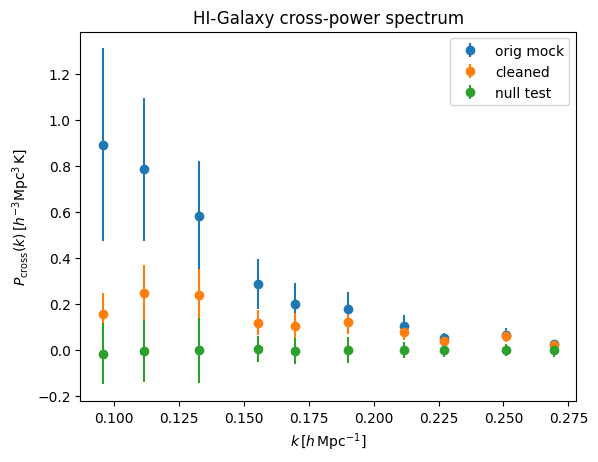

In [120]:
plt.errorbar(keff_c/ps.h,(pmock_1d_cross_arr).mean(0)*ps.h**3,
             yerr=pmock_1d_cross_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='orig mock')
plt.errorbar(keff_c/ps.h,(pmock_1d_cross_cleaned_arr).mean(0)*ps.h**3,
             yerr=pmock_1d_cross_cleaned_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='cleaned')
plt.errorbar(keff_c/ps.h,(pnull_1d_arr).mean(0)*ps.h**3,
             yerr=pnull_1d_arr.std(0)*ps.h**3,
             ls='none',
             marker='o',
             label='null test')
#plt.xscale('log')
#plt.yscale('symlog',linthresh=1e-2)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,[h^{-3}{\rm Mpc^3\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

You can then get the mean as well as the correlation between k-bins from transfer function:

In [121]:
tf_1d_mean = np.mean(tf_1d_arr, axis=0)
# a naive error bar
perror_1d_tf = np.sqrt((pdata_1d_cross**2/tf_1d_mean**2 + pdata_1d_hi * pdata_1d_gg/tf_1d_mean)/2)/np.sqrt(nmodes_c-1)
# correlation matrix
corr_mat_tf = np.corrcoef((1/tf_1d_arr).T)
cov_mat_tf = corr_mat_tf * perror_1d_tf[:,None] * perror_1d_tf[None,:]

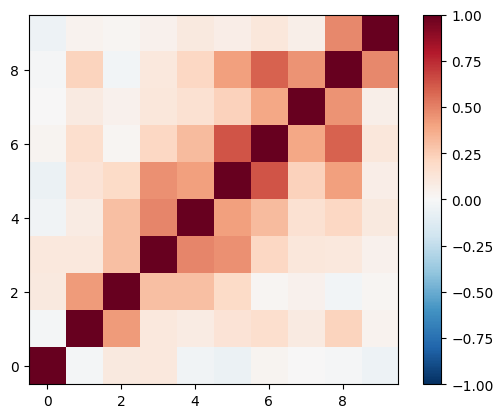

In [122]:
plt.imshow(corr_mat_tf, vmin=-1, vmax=1,cmap='RdBu_r', origin='lower')
plt.colorbar()

Now let's compare TF-corrected measurement with null test:

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

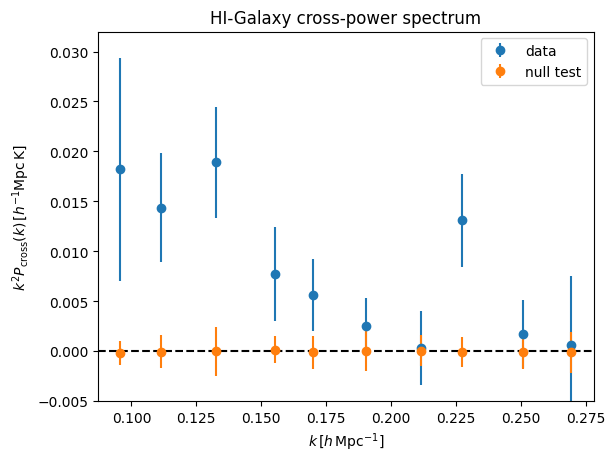

In [190]:
k_factor = keff_c**2 / ps.h**2
#plt.plot(keff_c/ps.h, pmod_1d_c*ps.h**3 * k_factor)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= (perror_1d_tf)*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')

plt.errorbar(keff_c/ps.h,(pnull_1d_arr).mean(0)*ps.h**3 * k_factor,
             yerr=pnull_1d_arr.std(0)*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='null test')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.005,0.032)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2 P_{\rm cross}(k)\,[h^{-1}{\rm Mpc\,K}]$')
plt.title('HI-Galaxy cross-power spectrum')

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

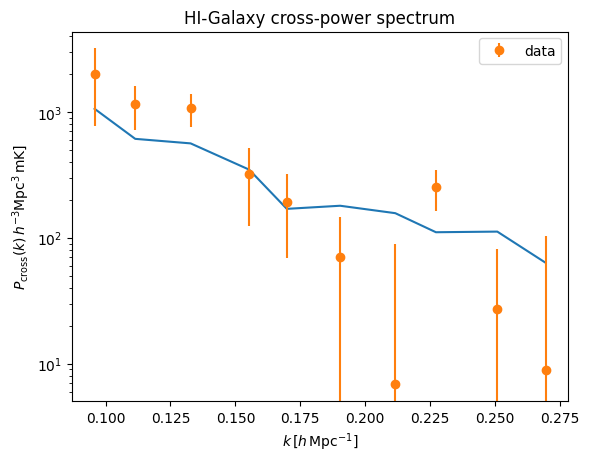

In [191]:
# check the power spectrum in volume unit:
k_factor = 1e3
plt.plot(keff_c/ps.h, pmod_1d_c*ps.h**3 * k_factor)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= perror_1d_tf*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')
plt.yscale('log')
#plt.ylim(1e1,5e3)
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm cross}(k)\,h^{-3}{\rm Mpc^3\,mK}]$')
plt.title('HI-Galaxy cross-power spectrum')

The detection significance is:

In [192]:
data_vector = (pdata_1d_cross/tf_1d_mean)
data_covariance = cov_mat_tf
np.sqrt(data_vector @ np.linalg.inv(data_covariance) @ data_vector)

np.float64(5.00609884516423)

## Step 6: model fitting


Fitting a model power spectrum is complicated for intensity mapping, as many observational effects come into play in the model power spectrum. Similar to transfer function calculation, `meer21cm` has sampler classes (e.g. `SamplerEmcee`), that takes `extract_model_fitting_inputs(ps)` as an input, which then automatically applies the same setting of modelling as your data analysis. 
Since the L-band data is limited in its signal-to-noise ratio and in its scales, we are typically only fittign an overall amplitude, which is controlled by $\Omega_{\rm HI} b_{\rm HI}$.

Nevertheless, `meer21cm` provides the full range of parameter variation from cosmological parameters to observational nuisance parameters. Moreover, it integrates sampling tools, `emcee` and `nautilus`, for automated fitting routine. Furthermore, which parameters to vary and the likelihood calculation are taken care of. All you need to do is to specify `params_name`, and the sampler will then only vary these parameters. The rest of the parameters are fixed to the values you set in `ps`.

Here, we show a simple example of fitting HI density $\Omega_{\rm HI}$ and beam size:

In [157]:
data_vector = (pdata_1d_cross/tf_1d_mean)
data_covariance = cov_mat_tf
# fit two parameters, overall HI density and beam size
# init position
ps.omega_hi = 5e-4
ps.sigma_beam_ch = ps.sigma_beam_ch.mean()
# tell sampler which parameters to vary
varied_params = ['omega_hi', 'sigma_beam_ch']
# specify priors
params_priors = [
    ('uniform', 1e-4, 2e-3), # flat prior, lower, upper
    # gaussian prior, mean, sigma
    ('gaussian', ps.sigma_beam_ch.mean(), 0.1), # beam model should be close to truth since it is a measurement

]
# here we use nautlius-sampler
sampler = SamplerEmcee(
    extract_model_fitting_inputs(ps), 
    data_vector, 
    data_covariance, 
    params_name=varied_params, 
    params_prior=params_priors,
    observables=['cross'], # only fit cross power
    save=True,
    save_filename='fitting.h5',
    nwalkers=4,
    nsteps=800,
    nthreads=32,
)

In [158]:
init_pos = np.array([5e-4, ps.sigma_beam_ch.mean()])
start_coord = (
    1 + np.random.uniform(-1e-2, 1e-2, size=(sampler.nwalkers, sampler.ndim))
) * init_pos[None, :]

In [ ]:
# resume = True if you are starting from a previous run
sampler.run(resume=False, progress=True, start_coord=start_coord)

It took about 60 minutes on a max node to run 4x800 steps

In [160]:
sampler.get_points().shape

(800, 4, 2)

In [161]:
sampler.get_log_prob().shape

(800, 4)

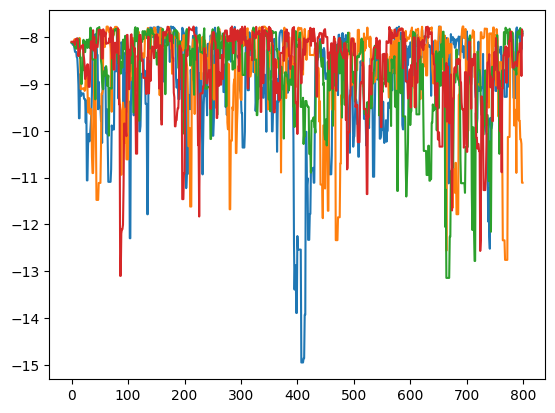

In [162]:
log_prob = sampler.get_log_prob()
for i in range(sampler.nwalkers):
    plt.plot(log_prob[:,i])

In [171]:
# best fit
best_fit = sampler.get_points().reshape((-1,2))[np.argmax(sampler.get_log_prob())]
best_fit

array([0.00070342, 0.55646252])

In [168]:
# posterior
points = sampler.get_points().reshape((-1,2))
points[:,0] = points[:,0]*1e3

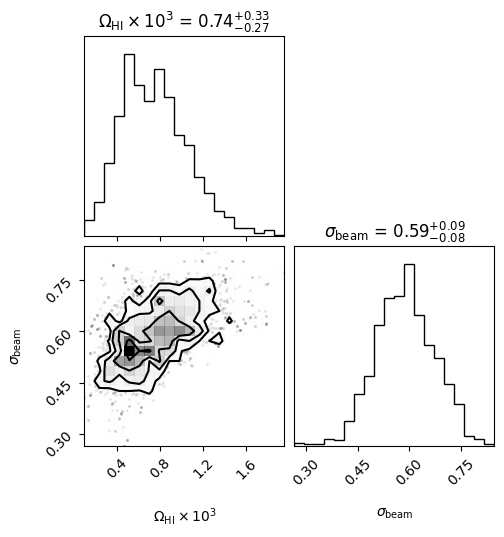

In [170]:
corner.corner(
    points,
    labels=[r'$\Omega_{\rm HI}\times 10^3$', r'$\sigma_{\rm beam}$'],
    show_titles=True,
);

Internally, `SamplerEmcee` provides a functionality `get_model_vector`, which it uses to calculate the model given the updated parameter values. Here we pass the best fit parameter and extract the model:

Text(0.5, 1.0, 'HI-Galaxy cross-power spectrum')

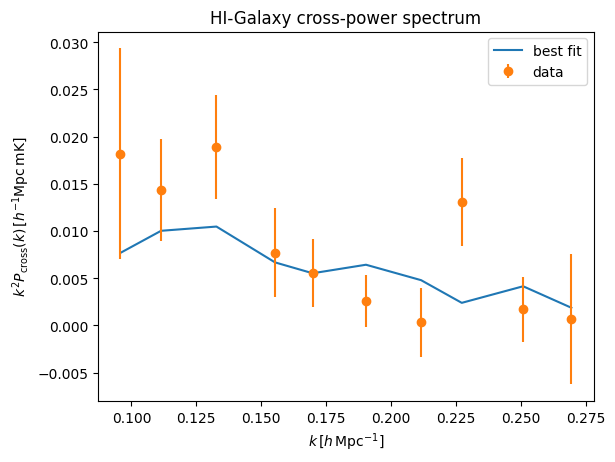

In [178]:
# a naive error bar 
k_factor = keff_c**2 / ps.h**2
#k_factor = 1e3
plt.plot(keff_c/ps.h, sampler.get_model_vector(best_fit)[0]*ps.h**3 * k_factor,label='best fit',)
plt.errorbar(keff_c/ps.h,(pdata_1d_cross/tf_1d_mean)*ps.h**3 * k_factor,
             yerr= perror_1d_tf*ps.h**3 * k_factor,
             ls='none',
             marker='o',
             label='data')
#plt.yscale('log')
#plt.ylim(1e1,9e3)
plt.legend()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2 P_{\rm cross}(k)\,[h^{-1}{\rm Mpc\,mK}]$')
plt.title('HI-Galaxy cross-power spectrum')